In [0]:
from read_datasetBreakfast import load_data, read_mapping_dict
import os

COMP_PATH = ''

''' 
training to load train set
test to load test set
'''
split = 'test'
#split = 'test'
train_split =  os.path.join(COMP_PATH, 'splits/train.split1.bundle') #Train Split
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

actions_dict = read_mapping_dict(mapping_loc)
if  split == 'training':
    data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels
if  split == 'test':
    data_feat_test = load_data( test_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features only

In [0]:
import pickle
print('saving first')
# saving data for future use
file1 = open('data_feat', 'wb')
pickle.dump(data_feat, file1)
file1.close()

file = open('data_labels', 'wb')
pickle.dump(data_labels, file)
file.close()

saving first


In [0]:
file = open('data_feat_test', 'wb')
pickle.dump(data_feat_test, file)
file.close()

In [0]:
# load data
import pickle
file = open('drive/My Drive/Colab Notebooks/data_feat', 'rb')
data_feat = pickle.load(file)
file = open('drive/My Drive/Colab Notebooks/data_labels', 'rb')
data_labels = pickle.load(file)
file = open('drive/My Drive/Colab Notebooks/data_feat_test', 'rb')
data_test = pickle.load(file)

# read segmentation file and convert from string to integer
with open('drive/My Drive/Colab Notebooks/training_segment.txt', 'r') as file:
    train_seg = file.readlines()
train_seg = [train_seg[i].split() for i in range(len(train_seg))]

for i in range(len(train_seg)):
    for j in range(len(train_seg[i])):
        train_seg[i][j] = int(train_seg[i][j])
        
with open('drive/My Drive/Colab Notebooks/test_segment.txt', 'r') as file:
    test_seg = file.readlines()
test_seg = [test_seg[i].split() for i in range(len(test_seg))]

for i in range(len(test_seg)):
    for j in range(len(test_seg[i])):
        test_seg[i][j] = int(test_seg[i][j])
        
num_train = len(data_feat)
num_test = len(data_test)

# data_feat
# data_labels
# data_test
# train_seg
# test_seg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
print(num_train)
print(data_feat[0].shape)
print(data_labels[0])
print(len(train_seg))
print(train_seg[0])
# import torch
# from platform import python_version
# print(python_version())
# print(torch.version.cuda)
# torch.__version__

1460
torch.Size([544, 400])
[1, 2]
1460
[9, 269, 474]


In [0]:
import torch
import numpy as np

one_seg_x = []
one_seg_y = []
data_label = []
# len(train) = len(train_seg)
for i in range(len(train_seg)):
    tmp = []
    for j in range(1, len(train_seg[i])):
        one_seg_x.append(data_feat[i][train_seg[i][j-1]:train_seg[i][j]])
        yy = [data_labels[i][j-1]] * (train_seg[i][j]-train_seg[i][j-1])
        one_seg_y.append(torch.Tensor(yy))
        tmp += yy
    data_label.append(torch.Tensor(tmp))

full_feat = []
for i in range(num_train):
    full_feat.append(data_feat[i][train_seg[i][0]:train_seg[i][-1]])

full_test = []
for i in range(num_test):
    full_test.append(data_test[i][test_seg[i][0]:test_seg[i][-1]])

one_seg_test = []
for i in range(num_test):
    for j in range(1, len(test_seg[i])):
        one_seg_test.append(data_test[i][test_seg[i][j-1]:test_seg[i][j]])

In [0]:
import torch
import numpy as np
def truncate_segment(data,segment,labels=None,first_n_frame = 60, add_stats='Yes'):
    raw_data = []
    truncated_data = []
    data_length = []
    data_label = []
    for i in range(len(data)):
        video = []
        tmp = []
        seg_tmp = [0]
        # print(str(i)+':')
        for j in range(len(segment[i])-1):
            # print(j)
            seg_start = segment[i][j]
            seg_end = segment[i][j+1]-1
            segment_length = seg_end - seg_start
            # raw_data.append(data[i][seg_start:seg_end])
            # data_length.append(segment_length)
            if segment_length < first_n_frame:
                this_segment = data[i][seg_start:seg_end]
                n_segment_frame = segment_length
                # this_segment = torch.zeros(first_n_frame,400)
                #this_segment[0:segment_length] =data[i][seg_start:seg_end]
            else:
                interval = segment_length//(first_n_frame-2)-1
                this_segment = data[i][seg_start]
                this_segment = torch.unsqueeze(this_segment,dim=0)
                for k in range(1,first_n_frame-1):
                    this_segment = torch.cat((this_segment, torch.unsqueeze(data[i][seg_start+interval*k],dim=0)),dim=0)
                this_segment = torch.cat((this_segment, torch.unsqueeze(data[i][seg_end],dim=0)),dim=0)
                n_segment_frame = first_n_frame
            
            this_segment = this_segment.float()
            if add_stats == 'Yes':
                max_tensor, max_inds = data[i][seg_start:seg_end].max(dim=0)
                min_tensor, min_inds = data[i][seg_start:seg_end].min(dim=0)
                mean_tensor = data[i][seg_start:seg_end].mean(dim=0)
                max_tensor = torch.unsqueeze(max_tensor,dim=0).float()
                min_tensor = torch.unsqueeze(min_tensor,dim=0).float()
                mean_tensor = torch.unsqueeze(mean_tensor,dim=0).float()
                this_segment = torch.cat((this_segment.float(),max_tensor,min_tensor,mean_tensor),dim=0)	
                n_segment_frame += 3
            video.append(this_segment)
            if labels != None:
                tmp += [labels[i][j]]*n_segment_frame
            seg_tmp.append(seg_tmp[j]+n_segment_frame)
        
        truncated_data.append(torch.cat(video,dim=0))
        if labels != None:
            data_label.append(torch.Tensor(tmp).long())
        data_length.append(seg_tmp)

    return truncated_data, data_length, data_label
        	
train_data_truncated, train_data_length, train_data_labels = truncate_segment(data_feat,train_seg,data_labels)
test_data_truncated, test_data_length, c = truncate_segment(data_test,test_seg,labels = None)

full_feat = train_data_truncated
data_label = train_data_labels
one_seg_test = test_data_truncated


In [59]:
print(full_feat[0].shape)

torch.Size([385, 400])


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_feat, data_label, test_size=0.2, random_state=7)

In [0]:
def cal_acc(pred, label):
    correct = 0
    v = label[0]
    cur = 0
    num = 1
    for i in range(len(label)):
        if label[i] == v:
            continue
        else:
            tmp = pred[cur:i]
            correct += torch.bincount(tmp).argmax() == v
            cur = i
            v = label[i]
            num += 1
    tmp = pred[cur:]
    correct += torch.bincount(tmp).argmax() == label[-1]
            
    return correct.item(), num

In [0]:
# Build Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda')

# torch.manual_seed(1)

class MyModel(nn.Module):
    def __init__(self, feature_size, hidden_size, output_size, num_layers):
        super(MyModel, self).__init__()
        self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self.linear1 = nn.Linear(hidden_size*2, 128)
        self.norm = torch.nn.LayerNorm(hidden_size*2)
        # self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
    def forward(self, data_feature):
        output, _ = self.lstm(data_feature)
        # combined = torch.cat((output, data_feature), dim=2)
        o = self.norm(output)
        o = self.linear1(o)
        # o = self.linear2(o)
        o = self.linear3(o)
        return o

In [0]:
def train(model, xtrain, ytrain, batch):
    correct = 0
    num = 0
    total_loss = 0
    model.train()
    for i in range(len(xtrain)):
        x = xtrain[i].float().to(device)
        y = ytrain[i].long()-1
        y = y.to(device)
        x = torch.unsqueeze(x, 0)
        out = model(x)
        out = torch.squeeze(out, 0)
        pred = torch.argmax(out, dim=1)
        # correct += (torch.bincount(pred).argmax() == y[0]).item()
        # acc = correct / (i+1)
        # a, b = cal_acc(pred, y)
        # correct += a
        # num += b
        correct += torch.sum(pred == y).item()
        num += len(y)
        loss = compare(out, y)
        total_loss += loss.item()
        avg_loss = total_loss / (i+1)
#         print(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % print_iter == 0:
            print('Batch: {} Iteration: {} Loss: {}, Acc: {}'.format(batch, i+1, avg_loss, correct/num))
    train_acc = correct / num
    train_err = total_loss / len(xtrain)
    return train_acc, train_err

In [0]:
def validate(model_trained, X_test, y_test):
    model_trained.eval()
    correct = 0
    num = 0
    total_loss = 0
    for i in range(len(X_test)):
        x = X_test[i].float().to(device)
        y = y_test[i].long()-1
        y = y.to(device)
        x = torch.unsqueeze(x, 0)
        out = model(x)
        out = torch.squeeze(out, 0)
        pred = torch.argmax(out, dim=1)
        # a, b = cal_acc(pred, y)
        # correct += a
        # num += b
        correct += torch.sum(pred == y).item()
        num += len(y)
        loss = compare(out, y)
        total_loss += loss.item()
    return correct / num, total_loss / (len(X_test))

In [65]:
print_iter = 100
model = MyModel(400, 200, 47, 3).to(device)
compare = nn.CrossEntropyLoss()
param = model.parameters()
optimizer = torch.optim.Adam(param, lr = 0.0001)
batch = 30

best_val = 0
tacc = []
tl = []
vacc = []
vl = []
for b in range(batch):
    acc, loss = train(model, X_train, y_train, b)
    tacc.append(acc)
    tl.append(loss)
    val_score, vloss = validate(model, X_test, y_test)
    vacc.append(val_score)
    vl.append(vloss)
    print('Validation Acc: ', val_score)
    print(tacc, tl, vacc, vl)
    if val_score > best_val:
        best_val = val_score
        torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/best_model')

Batch: 0 Iteration: 100 Loss: 3.536044034957886, Acc: 0.08988271771366946
Batch: 0 Iteration: 200 Loss: 3.304328444004059, Acc: 0.1166622975407905
Batch: 0 Iteration: 300 Loss: 3.1685609757900237, Acc: 0.1431546743018205
Batch: 0 Iteration: 400 Loss: 3.05218000292778, Acc: 0.1729099592099823
Batch: 0 Iteration: 500 Loss: 2.9748231341838838, Acc: 0.1848886855748704
Batch: 0 Iteration: 600 Loss: 2.882560446659724, Acc: 0.20892940915946093
Batch: 0 Iteration: 700 Loss: 2.817133662189756, Acc: 0.2120365885193778
Batch: 0 Iteration: 800 Loss: 2.7645564084500074, Acc: 0.21270103865728385
Batch: 0 Iteration: 900 Loss: 2.703455931544304, Acc: 0.21982095347666641
Batch: 0 Iteration: 1000 Loss: 2.652508484363556, Acc: 0.2303726959306874
Batch: 0 Iteration: 1100 Loss: 2.611957993561571, Acc: 0.23233568333469595
Validation Acc:  0.3171160944783171
[0.2396623883482522] [2.5912630836134904] [0.3171160944783171] [2.0804858059711653]
Batch: 1 Iteration: 100 Loss: 2.085034744143486, Acc: 0.339815314100

KeyboardInterrupt: ignored

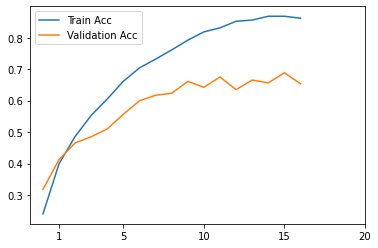

[0.2396623883482522, 0.39912948671902393, 0.4860566537034649, 0.5531334961105066, 0.6053237940652053, 0.6618075087099288, 0.7041821512804581, 0.7319068482580675, 0.7614087010829194, 0.7922416889321825, 0.8186272576806705, 0.8313625643053318, 0.8523393978665603, 0.8561340385826662, 0.8683204784838916, 0.8683055578350991, 0.861993057635269]


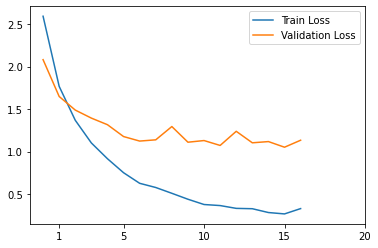

In [66]:
import matplotlib.pyplot as plt

plt.plot(tacc, label='Train Acc')
plt.plot(vacc, label='Validation Acc')
plt.xticks([1,5,10,15,20])
plt.legend()
plt.show()

plt.plot(tl, label='Train Loss')
plt.plot(vl, label='Validation Loss')
plt.xticks([1,5,10,15,20])
plt.legend()
print(tacc)

In [0]:
# function to generate prediction for test data
def gen_out(model, data, seg):
    ans = []
    for i in range(len(data)):
        x = data[i].float().to(device)
        x = torch.unsqueeze(x, 0)
        out = model(x)
        out = torch.squeeze(out, 0)
        pred = torch.argmax(out, dim=1)
        for j in range(1, len(seg[i])):
            start = seg[i][j-1]
            end = seg[i][j]
            tmp = pred[start:end]
            cor = torch.bincount(tmp).argmax().item()+1
            ans.append(cor)
    return ans

In [0]:
model = MyModel(400, 200, 47, 3).to(device)
# load saved best model
model.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/best_model'))
model.eval()
ans = gen_out(model, one_seg_test, test_data_length)

In [0]:
# post processing to average from many model predictions
# input: all_ans is list of ans calculated from gen_out
def avg_pred(all_ans):
    num_pred = len(all_ans[0])
    ans = []
    for i in range(num_pred):
        tmp = []
        for j in range(len(all_ans)):
            tmp.append(all_ans[j][i])
        counts = np.bincount(tmp)
        ans.append(np.argmax(counts))
    return ans

In [0]:
import csv
with open('submission.csv', 'w') as file:
    wr = csv.writer(file)
    wr.writerow(['Id', 'Category'])
    for i in range(len(ans)):
        wr.writerow([i, ans[i]])